In [1]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

In [2]:
class GameOfLifeAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.live = self.random.choice([0, 1])
        self.next_state = None

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        
        count = 0
        for neighbor in neighbors:
            count += neighbor.live

        self.next_state = self.live
        if self.next_state == 1:
            if count < 2 or count > 3:
                self.next_state = 0

        else:
            if count == 3:
                self.next_state = 1

    def advance(self):
        self.live = self.next_state

In [3]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (agent, (x, y)) in model.grid.coord_iter():
        grid[x][y] = agent.live
    return grid

In [4]:
class GameOfLifeModel(Model):
    def __init__(self, width, height):
        self.schedule = SimultaneousActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid})
        
        for (content, (x, y)) in self.grid.coord_iter():
            agent = GameOfLifeAgent((x, y), self)
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
GRID_SIZE = 50
MAX_GENERTIONS = 200

model = GameOfLifeModel(GRID_SIZE, GRID_SIZE)
for i in range (MAX_GENERTIONS):
    model.step()

In [6]:
all_grids = model.datacollector.get_model_vars_dataframe()

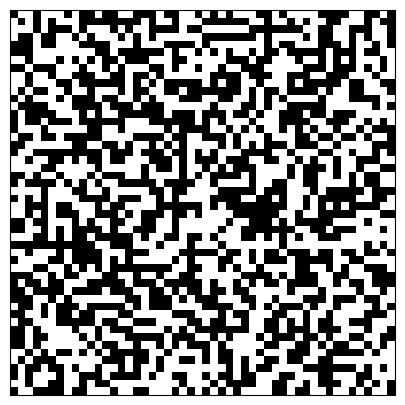

In [8]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0][0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(all_grids.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERTIONS)

In [9]:
anim